In [1]:
# computation and plotting libraries

import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, resize
import math
#import tomopy

#### Задание 1.1.

Реализуйте функцию ``radon2d(image, ntheta, nshift, radsupp)``, которая вычисляет преобразование Радона от изображения
``image`` - матрицы размером $N\times N$ пикселей, и возвращает соответствующие лучевые данные в виде матрицы размера ``ntheta x nshift``. В качестве помощи, Вам предлагается уже готовая функция `line_projector(image, phi, shift, radsupp)`, которая вычисляет интеграл вдоль соответствующей прямой.

In [2]:
def radon2d(image, ntheta, nshift):
    proj = np.zeros((ntheta, nshift))
    deltashift = 2 / nshift
    for i in range(nshift):
      for j in range(ntheta):
        phi = 2 * math.pi * j / ntheta
        shift = -1.0 + i * deltashift
        proj[j][i] = line_projector(image, phi, shift, radius=1.0)
    return proj


def line_projector(image, phi, shift, radius=1.0):
    
    # line is outside of the surrounding square
    if (shift > radius*np.sqrt(2)):
        return 0
    
    # image size
    npixels = image.shape[0]
    dx = 2*radius / npixels # pixel's side length 
    
    # set the geometry of the line
    line_center = np.array([[shift * np.cos(phi)], [shift * np.sin(phi)]])
    direction = np.array([[-np.sin(phi)], [np.cos(phi)]])
    dstep = dx / 2
    
    # set integration borders along the line
    lim_left = -np.sqrt(2*radius-shift**2)
    lim_right = -lim_left
    npoints = 2*np.ceil(2*np.sqrt(2*radius-shift**2)/dstep).astype(int) + 1
    
    # get sampling points along the line
    line_points = line_center +  np.multiply(direction, np.linspace(lim_left, lim_right, npoints))
    
    line_pixels = np.floor((line_points + radius)/dx).astype(int) # integers (i,j) of pixel coordinates
    line_pixels[1, :] = npixels - 1 - line_pixels[1, :]
    
    line_pixels = line_pixels[:, ((line_pixels[0] > -1)*(line_pixels[0] < npixels))
                              *((line_pixels[1] > -1)*(line_pixels[1] < npixels))]
    
    line_image_values = image[line_pixels[1, :], line_pixels[0, :]]
    proj_value = np.sum(line_image_values) * dx

    return proj_value

### Фантомы для тестирования

Алгоритм вычисления преобразований Радона мы протестируем на двух примерах (в инженерной литературе такие примеры  называются  - фантомами):
   1. Фантом 1 - кольцо. Простейший нетривиальный пример, который мы сгенерируем сами и на 
      котором можно тестировать наш алгоритм.
   2. Фантом 2 - Shepp-Logan Phantom - стандарнтный фантом, используемый с 1974-го года, используемый для 
      тестирования алгоритмов восстановления в различных томографиях 
      (помимо него существует и множество других стандартных 
      [фантомов](https://en.wikipedia.org/wiki/Imaging_phantom)).  
      
Для генерации последнего, мы будем использовать библиотеку <a href="https://tomopy.readthedocs.io/en/latest/index.html"><span class="toc-item-num">TomoPy</span></a>, которая содержит различные методы и функции для томографических восстановлений.

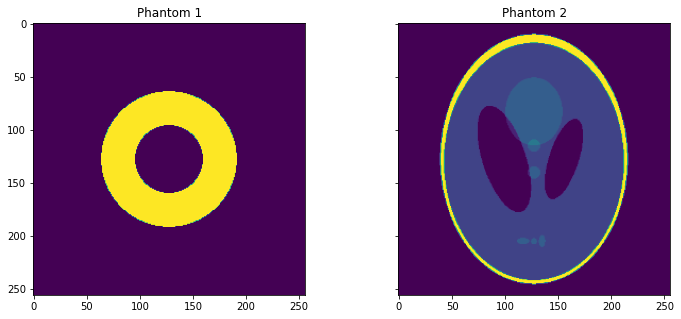

In [3]:
def circular_phantom(N):
    
    lin = np.linspace(-1,1, N)
    [XX, YY] = np.meshgrid(lin, lin)
    RR = np.sqrt(XX**2 + YY**2)
    circ_image = np.zeros((N,N))
    circ_image[RR < 0.5] = 1.
    circ_image[RR < 0.25] = 0.
    
    return circ_image


N = 256
phantom1 = circular_phantom(N)
phantom2 = resize(shepp_logan_phantom(), (N, N),
                       anti_aliasing=True) # Shepp-Logan Phantom

# plot 2D-phantoms

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(phantom1)
axs[0].set_title('Phantom 1')
axs[1].imshow(phantom2)
axs[1].set_title('Phantom 2')
plt.show()


**Задание 1.2.**

Вычислите преобразования Радона для фантомов 1,2 с параметрами ``nshift = 256, ntheta = 128``.
Постройте графики вычисленных преобразований Радона при помощи функции `plt.imshow(...)` (в томографической литературе такие изображения называются **синограммами**). Что вы можете сказать про эти функции (гладкость по сравнению с гладкостью фантомов, периодичность) - прокомментируйте ? 

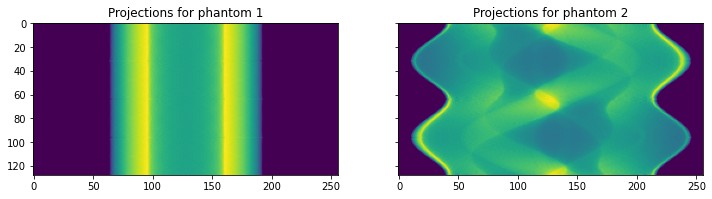

In [4]:
nshift = 256
ntheta = 128

proj_phantom1 = radon2d(phantom1, ntheta, nshift)
proj_phantom2 = radon2d(phantom2, ntheta, nshift)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axs[0].imshow(proj_phantom1)
axs[0].set_title('Projections for phantom 1')
axs[1].imshow(proj_phantom2)
axs[1].set_title('Projections for phantom 2')
plt.show()

Получились более гладкие функции, видна переодичность, особенно на фантоме 2, можно даже сопоставить контур на фантоме с периодической функцией на преобразовании Радона.

**Задание 2.1**

Реализуйте функцию ``adjradon2d(proj, npixels, radius)``, которая вычисляет двойственное преобразование Радона по проекционным данным. Входные параметры следующие:

 * ``proj`` - матрица проекционных данных размера ``(ntheta, nshift)``

 * ``radius`` - максимальное расстояние от нуля до границы носителя

 * ``npixels`` - кол-во пикселей на отрезке `[-radius, radius]`

Выходные параметры: матрица/изображение размера `npixels x npixels`

In [5]:
def adjradon2d(proj, npixels, radius):
    adjradon = np.zeros((npixels, npixels))
    interp_points = np.zeros(npixels**2)

    nshift = len(proj[0])
    ntheta = len(proj)

    points = np.zeros(nshift)
    values = np.zeros(nshift)

    deltashift = 2 / nshift
    deltaphi = 2 * math.pi / ntheta

    x = np.zeros(npixels)
    for i in range(npixels):
      x[i] = -1.0 + 2 * i / npixels

    for i in range(ntheta):
      phi = 2 * math.pi * i / ntheta
      for j in range(npixels**2):
        interp_points[j] = x[j//npixels]*np.cos(phi) + x[j%npixels]*np.sin(phi)
      for j in range(nshift):
        points[j] = -1.0 + j * deltashift
        values[j] = proj[i][j]
        
      interpolvalues = np.interp(interp_points, points, values, -radius, radius)
      for j in range(npixels**2):
        adjradon[j%npixels][j//npixels] += deltaphi * interpolvalues[j]

    return adjradon

**Задание 2.2**

Вычислите и постройте изображения $R^*Rf$ для фантомов 1, 2 из Задания 1.2. 
Какие отличия от оригинальных изображений фантомов Вы видите ? (гладкость, сингулярность, границы, компактность носителя и др.) Можете ли вы объяснить этот результат ?

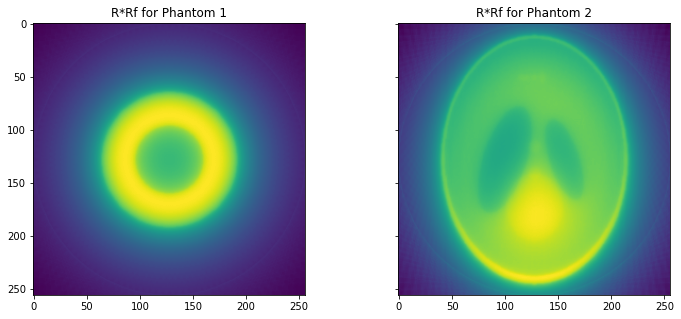

In [6]:
npixels = 256
radius = 1.0

adj_phantom1 = adjradon2d(proj_phantom1, npixels, radius)
adj_phantom2 = adjradon2d(proj_phantom2, npixels, radius)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axs[0].imshow(adj_phantom1)
axs[0].set_title('R*Rf for Phantom 1')
axs[1].imshow(adj_phantom2)
axs[1].set_title('R*Rf for Phantom 2')
plt.show()

Видно, что контуры стали более размазанными, то есть повысилась гладкость изображения, разрывов в 1 производной точно нет. Это связано с тем, что преобразование $R^*R$ по факту работает как предобуславливатель с хорошими свойствами, накладывая на функцию дополнительную гладкость, сглаживая разрывы.

**Задание 3.1**


 1. Выразите $L_k (s_i, \theta_j)$ через преобразование Радона от некоторой функции $f$. Какая это функция 
    для произвольного пикселя $k$? Мы будем рассматривать изображения размером $64 \times 64$ пикселей, пусть 
    также $N_s = 64, \, N_\theta=64$.
    Какой размер матрицы $R$ соответствует данным параметрам?
    
    
 2. Реализуйте ниже функцию ``matrixradon2d(npixels, ntheta, nshifts, radius=1.0)``, которая возвращает матрицу $R$ для изображений $N$. Попробуйте оценить сложность вашего алгоритма в нотации $O(\dots), \Omega(\dots)$.
    
    
 3. Вычислите преобразования Радона от фантомов 1, 2 из параграфа 1 при помощи данной матрицы,
    сравните ответы с теми, которые получались ранее (постройте графики "разниц" изображений). 
    
    
 4. ** (факультативный и сложный вопрос) Является ли матричная аппроксимация преобразования Радона 
    аппроксимацией в смысле нормы операторов в бесконечномерных пространствах. 
    Например, приближают ли сингулярные значения 
    матрицы $R$ сингулярные значения оператора $R$? (Если не можете формально доказать, дайте хотя бы свою 
    интуицию) Этот вопрос связан с очень простым вопросом: **имеют ли смысл и корректны ли наши численные исследования, ведь не всякий линейный оператор в бесконечномерном пр-ве можно приблизить матрицей?**

В качестве помощи, используйте заготовку программы `matrixradon2d(...)` в клетке ниже.
    
<div class="lev1"><a href="#Содержание"><span class="toc-item-num"></span>Вернуться к содержанию</a></div>

$1$. Так как мы предполагаем, что 
изображение - локально-постоянная функция с постоянными значениями внутри своих пикселей, 
то интеграл вдоль луча можно записать в виде следующей конечной суммы:

\begin{equation}
    Rf(s_i, \theta_j) = \sum\limits_{k=1}^{N_p}f_k L_k(s_i, \theta_j),
\end{equation}

где $f_k$ - значение $f$ в пикселе $k$, $L_k(s_i, \theta_j)$ - длина пересечения прямой $(s_i, \theta_j)$ с 
пикселем $k$.

Тогда функция $f$ должна быть постоянная для пикселя $k$. 

Преобразование Радона можно рассматривать как умножение вектора на матрицу: 

\begin{equation}
    Rf = Lf, \text{ где } L \text{ - матрица из длин пересечений } \{L_k\}, \, L\in 
    \mathrm{Mat}_{N_sN_\theta, N_p}(R), 
\end{equation}

где $f$ - вектор размерности $N_p = N^2$ соответствующий нашему изображению.

Таким образом, $R$ является линейным оператором $R : R^{N_p} \rightarrow R^{N_sN_\theta}$.

Тогда $R$ имеет размерность $N_sN_\theta \times N_p$.

Должно быть выполнено $(R-L)f = 0$, то есть столбец $f$ должен быть собственным вектором для матрицы $R-L$, которая должна быть вырожденной.

Для этого задания надо записать некоторую геометрию.

У нас есть пиксель, для него хотим найти расстояние между точками пеерсечения луча границ пикеля. Знаем, какой параметризацией задается луч. 

$$x = scos\phi - t sin\phi, y = ssin\phi + t cos\phi$$

И зама прямая задается изменением параметра $t$. У нас через пиксель проходит 1 прямая с заданными $s$ и $\phi$. То есть будет 2 точки с разными значениями $t$.

$$x_1 = scos\phi - t_1 sin\phi, y_1 = ssin\phi + t_1 cos\phi$$

$$x_2 = scos\phi - t_2 sin\phi, y_2 = ssin\phi + t_2 cos\phi$$

Расстояние между 2 точками отпередяется как 

$$\sqrt{(x_2-x_1)^2+(y_2-y_1)^2} = \sqrt{(sin^2\phi + cos^2\phi)(t_2-t_1)^2} = |t_2 - t_1|$$

То есть надо всего лишь найти конкретные значения параметров для прямой на пикселе. 


In [10]:
# npixels - pixels per image dimension, N x N = npixels x npixels
# ntheta  - number of projections
# nshifts - number of lines per projection

def matrixradon2d(npixels, ntheta, nshift, radius=1.0):
    
    radon_matrix = np.zeros((ntheta*nshift, npixels**2))
    
    #1. init geometry/sizes  
    dx = 2.0 * radius / npixels # pixel's sidelength
    shifts = np.linspace(-radius + dx/2, radius-dx/2, nshift)
    theta = np.linspace(0, 2*np.pi, ntheta, endpoint = False)
    
    # 2. YOUR CODE HERE
    for i_pixel in range(npixels**2):
        
        # 2.1 pixel's coordinates
        pixel_coords = np.array([-radius + dx/2 + dx*(i_pixel % npixels),  
                                  radius - dx/2 - dx*(i_pixel // npixels)])
        
        # 2.2 create one-pixel image 
        image = np.zeros(npixels**2)
        image[i_pixel] = 1.0
        image = np.reshape(image, (npixels, npixels))
    
        # 2.3 compute matrix projection vector 
        proj_vector = np.zeros((ntheta, nshift))
        
        for i_theta in range(ntheta):
            # 2.4 find shifts that are needed for computation for the pixel, others are 0's
              phi = theta[i_theta]

              s = pixel_coords[0]*np.cos(phi) + pixel_coords[1]*np.sin(phi)
              i_shift = np.int( nshift*(1+s)/2)
              if (i_shift >= nshift or i_shift < 0):
                break

              if (phi == 0 or phi == np.pi or phi == 2*np.pi or phi == np.pi/2 or phi == 3*np.pi/2):
                  phi += 0.001

              ind1 = False
              ind2 = False
              ind3 = False
              ind4 = False

              res = 0
              tau = math.sqrt(2-s**2)

              x = pixel_coords[0] - dx/2
              t = (s*np.cos(phi) - x) / np.sin(phi)
              y = s*np.sin(phi) + t*np.cos(phi)
              if (y <= pixel_coords[1]+dx/2 and y >= pixel_coords[1]-dx/2 and t >= -tau and t <= tau):
                  t1 = t
                  ind1 = True

              x = pixel_coords[0] + dx/2
              t = (s*np.cos(phi) - x) / np.sin(phi)
              y = s*np.sin(phi) + t*np.cos(phi)
              if (y <= pixel_coords[1]+dx/2 and y >= pixel_coords[1]-dx/2 and t >= -tau and t <= tau):
                   t2 = t
                   ind2 = True

              y = pixel_coords[1] - dx/2
              t = (y - s*np.sin(phi)) / np.cos(phi)
              x = s*np.cos(phi) - t*np.sin(phi)
              if (x <= pixel_coords[0]+dx/2 and x >= pixel_coords[0]-dx/2 and t >= -tau and t <= tau):
                  t3 = t
                  ind3 = True

              y = pixel_coords[1] + dx/2
              t = (y - s*np.sin(phi)) / np.cos(phi)
              x = s*np.cos(phi) - t*np.sin(phi)
              if (x <= pixel_coords[0]+dx/2 and x >= pixel_coords[0]-dx/2 and t >= -tau and t <= tau):
                t4 = t
                ind4 = True
                
              if (ind1 == True and ind2 == True):
                res = np.abs(t2 - t1)
              if (ind1 == True and ind3 == True):
                res = np.abs(t3 - t1)
              if (ind1 == True and ind4 == True):
                res = np.abs(t4 - t1)
              if (ind2 == True and ind3 == True):
                res = np.abs(t3 - t2)
              if (ind2 == True and ind4 == True):
                res = np.abs(t4 - t2)
              if (ind3 == True and ind4 == True):
                res = np.abs(t4 - t3)

              if (res != 0):
                proj_vector[i_theta][i_shift] = res
            
        # return column
        radon_matrix[:, i_pixel] = np.reshape(proj_vector, ntheta*nshift)
    
    return radon_matrix


In [11]:
# YOUR CODE HERE 

radon2d_matrix_64 = matrixradon2d(64, 64, 64, radius=1.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


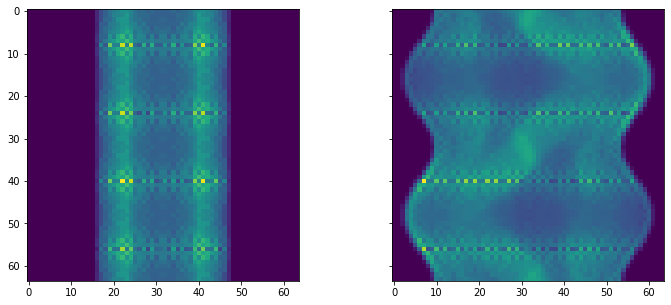

In [12]:
# RUN THE CELL

# computation of low-resolution projections and plotting

# 1. low-resolution phantoms, f
N = 64
phantom1_64 = np.reshape(circular_phantom(N), (N**2,1))
phantom2_64 = np.reshape(resize(shepp_logan_phantom(), (N, N), anti_aliasing=True), (N**2,1))

# 2. low-resolution projections, projection = R * f, * - matrix vector product
proj_phantom1_64 = np.reshape(np.dot(radon2d_matrix_64, phantom1_64), (64, 64))
proj_phantom2_64 = np.reshape(np.dot(radon2d_matrix_64, phantom2_64), (64, 64))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axs[0].imshow(proj_phantom1_64)
axs[1].imshow(proj_phantom2_64)
plt.show()

Сложность программы $O(N^2 \cdot N_s \cdot N_{\theta})$, потому что там 3 вложенных цикла, для каждого пикселя идет пробег по всем вариантам луча, то есть по всем вариантам параметров $s$ и $\theta$, а потом простые математические операции типа умножение, сложение и сравнение.

Графики ошибок

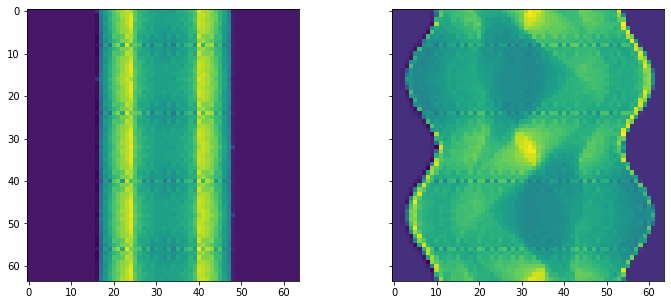

In [8]:
nshift = 64
ntheta = 64

proj_phantom1 = radon2d(phantom1, ntheta, nshift)
proj_phantom2 = radon2d(phantom2, ntheta, nshift)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axs[0].imshow(proj_phantom1 - proj_phantom1_64)
axs[1].imshow(proj_phantom2 - proj_phantom2_64)
plt.show()

**Задание 3.2**

Постройте двумерное изображение матрицы при помощи функции ``plt.imshow(...)``. 
Является ли матрица преобразования $R$ разреженной? Оцените их количество и дайте объяснение. 

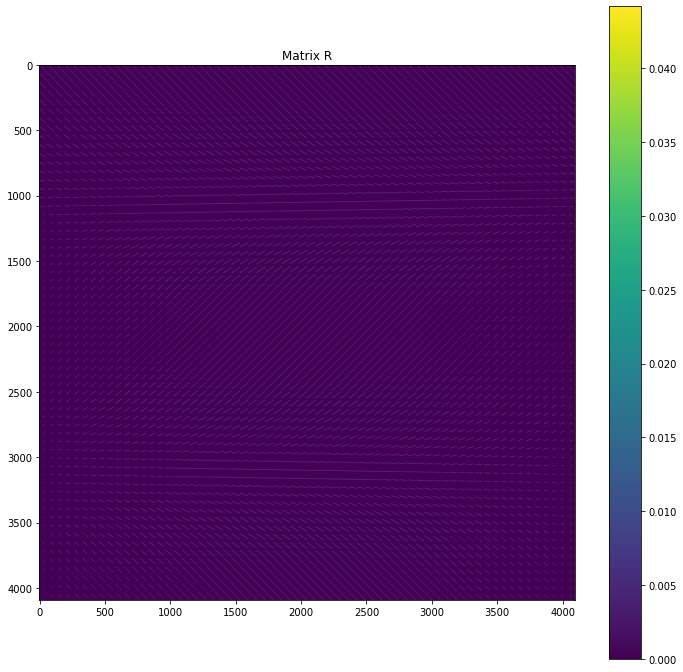

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(radon2d_matrix_64)
axs.set_title('Matrix R')
fig.colorbar(im, ax=axs)
plt.show()

Матрица получилась очень разряженная. Количество ненулевых элементов порядка $O(N)$.

**Задание 3.3** 


  1. Реализуйте программу, которая вычисляет матрицу преобразования $R^*$ в виде программы ``matrixadjradon2d(...)``, аналогично предыдущему заданию (прежде чем выполнять это задание подумайте над пунктом 2). 

  2. Изобразите эту матрицу с помощью функции ``plt.imshow(...)`` Подумайте, как связаны матрицы преобразований $R$, $R^*$? (Подсказка: $R^*$ и $R$ - формальные дуальные операторы относительно $L^2$-нормы)

$(Rf, x) = (f, R^*x)$

$Rfx^T = f(R^*x)^T$

$R f x^T = f x^T (R^*)^T$

Так как $f \cdot x^T$ - число, то вполне логично, что $R = (R^*)^T$, то есть $R^* = R^T$.

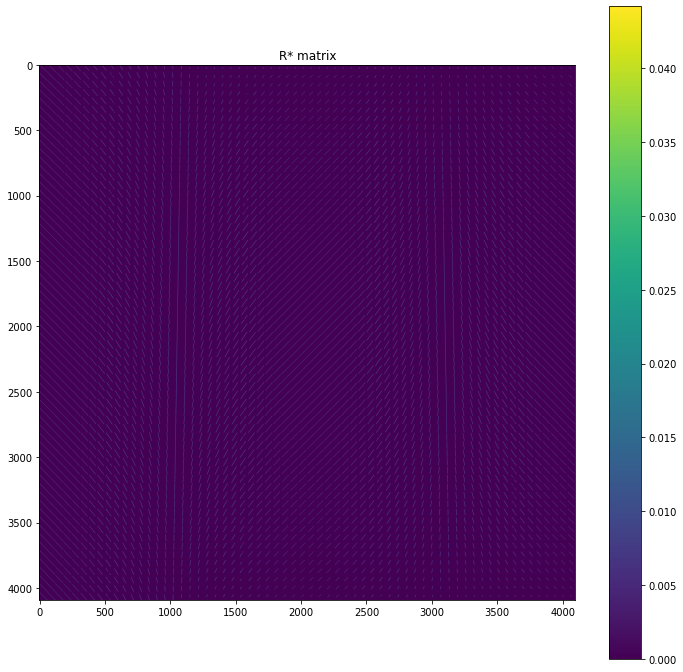

In [13]:
def matrixadjradon2d(npixels, ntheta, nshift, radius=1.0):
    adjradon_matrix = np.transpose(radon2d_matrix_64)
    return adjradon_matrix

adjradon2d_matrix_64 = matrixadjradon2d(64, 64, 64)
fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)
im = axs.imshow(adjradon2d_matrix_64) 
axs.set_title('R* matrix')
fig.colorbar(im, ax=axs)
plt.show()

**Задание 3.4**


Постройте изображения $R^*Rf$ для функций $f$, соответствующим фантомам 1, 2. Тем самым проверьте правильность вашего алгоритма, сравнив полученные изображения с изображениями из задания 2.2.

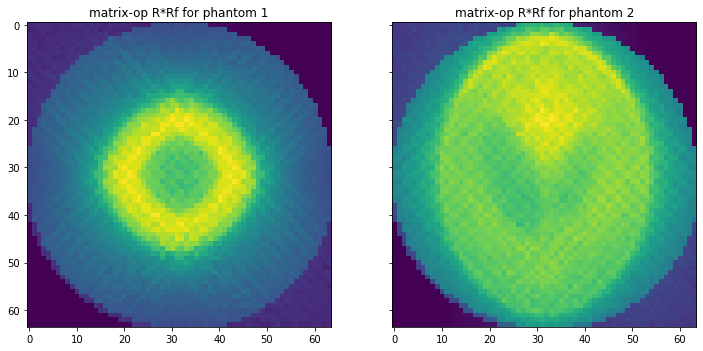

In [14]:
proj_phantom1 = np.dot(radon2d_matrix_64, phantom1_64)
proj_phantom2 = np.dot(radon2d_matrix_64, phantom2_64)

normal_phantom1_64 = np.dot(adjradon2d_matrix_64, proj_phantom1)
normal_phantom2_64 = np.dot(adjradon2d_matrix_64, proj_phantom2)

fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

axs[0].imshow(np.reshape(normal_phantom1_64, (64, 64)))
axs[0].set_title('matrix-op R*Rf for phantom 1')
axs[1].imshow(np.reshape(normal_phantom2_64, (64, 64)))
axs[1].set_title('matrix-op R*Rf for phantom 2')
plt.show()

**Задание 4.1**


1. Используя матрицу преобразования $R$ из задания 3, и проекционные данные для фантомов 1, 2 из задания 2, восстановите изображения фантомов. Так как даже для небольших размеров изображений вычисление матрицы $R$ выходит за рамки возможностей ваших персональных компьютеров, проделайте вычисления для небольших разрешений изображений и синограмм (например, изображения $64 \times 64$ пикселя, синограмма размера $64 \times 64$).


2. Примените формулу обратной проекции FBP (filtered backprojection algorithm), для восстановления фантомов 1, 2. Функция ``iradon(...)`` нахоидится в библиотетке ``skimage.transform``, примеры её применения можно найти 
    здесь <a href="https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html"><span class="toc-item-num"></span>Skimage Radon transform</a>.
    
   
 
3. *Можете ли вы объяснить разницу в восстановлениях при помощи матрицы $R$ и при помощи алгоритма FBP?

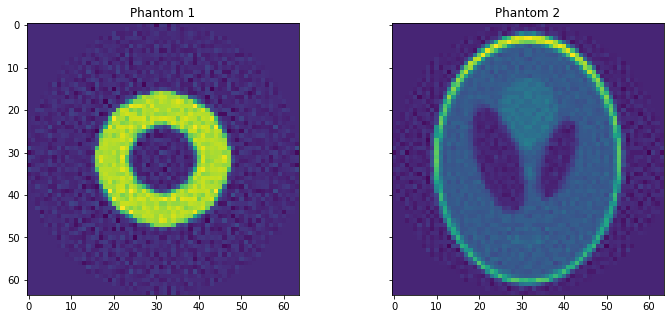

In [14]:
# 1. least-squares

phantom1_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, proj_phantom1, rcond=None)
phantom2_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, proj_phantom2, rcond=None)

phantom1_linalg = np.reshape(phantom1_linalg, (64, 64))
phantom2_linalg = np.reshape(phantom2_linalg, (64, 64))


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(phantom1_linalg)
axs[0].set_title('Phantom 1')
axs[1].imshow(phantom2_linalg)
axs[1].set_title('Phantom 2')
plt.show()

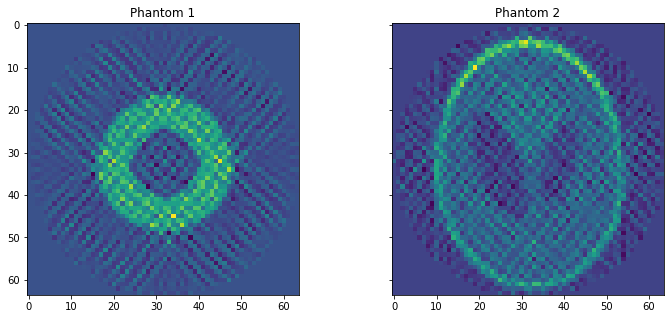

In [15]:
# 2. FBP

from skimage.transform import iradon

recon1_64_fbp = iradon(proj_phantom1_64[0:31, :].transpose())
recon2_64_fbp = iradon(proj_phantom2_64[0:31, :].transpose())

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(recon1_64_fbp)
axs[0].set_title('Phantom 1')
axs[1].imshow(recon2_64_fbp)
axs[1].set_title('Phantom 2')
plt.show()

Визуально разница в том, что шумы сконцентрированы в носителе и изображение более гладкое, особенно это видно в изображении "сердца", контраст между ним и областью его окружающим слабее, чем при восстановленном с помощью np.linalg.lstsq() изображении.

#### Задание 4.2 

Вычислите детерминант матрицы $R$? (выберите параметры при которых она квадратная) Как вы можете объяснить / прокомментировать полученный  результат ?

In [16]:
print(np.linalg.det(radon2d_matrix_64))

0.0


Детрминант равен нулю, скорее всего это связано с превышением машинной точности, то есть там где должны были быть не совсем нули оказались нули из-за выхода за пределы машинной точности, и с тем, что это всё-таки уже дискретная задача.

**Упражнение 4.3 - Лемма.**

Пусть $A$ - линейный ограниченный оператор между гильбертовыми пространствами $H, K$. Докажите, что $A$ - инъективен тогда и только тогда, когда инъективен оператор $A^*A$. 

Инъективность = существование левого обратного оператора.

Пусть для $A^*A$ это верно. Тогда существует $(A^*A)^{-1}$, такой что $(A^*A)^{-1}A^*A = E$.

Тогда определено $((A^*A)^{-1}A^*)A = E$, то есть $(A^*A)^{-1}A^*$ - левый обратный для $A$, значит он инъективен.

В другую сторону.

Пусть существует $A^{-1}$, такой что $A^{-1}A = E$. Тогда будет существовать и $A^{-*}$, такой что $A^{-*}A^* = E$

Тогда $A^{-1}A^{-*}A^*A = E$, то есть $A^{-1}A^{-*}$ - левый обратный для $A^*A$, значит он инъективен.

**Задание 4.4**
Постройте график сингулярных значений оператора $R$. Как это помогает ответить на вопрос задачи 4.2?

In [ ]:
U, S, V = np.linalg.svd(np.dot(adjradon2d_matrix_64, radon2d_matrix_64))

plt.figure(figsize = (12, 5))
plt.plot(range(4096), S)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Сингулярные значения быстро убывают. Ну а из-за того, что многие собственные значения равны нулю детерминант равен 0, но опять же они равны 0 из-за машинной точности, на самом деле это не так.

**Задание 4.6**

Восстановите изображения из зашумленных данных при помощи метода наименьших квадратов и FBP. Как вы можете объяснить полученный результат? Сравните, как отличаются размеры видимых объектов на синограмме и восстановленном изображении. Где видны более мелкие детали?

In [ ]:
sigma1 = 0.05 * np.max(proj_phantom1_64[:])
sigma2 = 0.05 * np.max(proj_phantom2_64[:])

noisy_proj_phantom1_64 = proj_phantom1_64 + np.random.normal(0, sigma1, proj_phantom1_64.shape) 
noisy_proj_phantom2_64 = proj_phantom2_64 + np.random.normal(0, sigma2, proj_phantom2_64.shape) 

fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

axs[0].imshow(noisy_proj_phantom1_64)
axs[1].imshow(noisy_proj_phantom2_64)
plt.show()

In [ ]:
# 1. least-squares

phantom1_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom1_64, (4096, 1)), rcond=None)
phantom2_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom2_64, (4096, 1)), rcond=None)

phantom1_linalg = np.reshape(phantom1_linalg, (64, 64))
phantom2_linalg = np.reshape(phantom2_linalg, (64, 64))


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(phantom1_linalg)
axs[0].set_title('Phantom 1')
axs[1].imshow(phantom2_linalg)
axs[1].set_title('Phantom 2')
plt.show()



In [ ]:
# 2. FBP

from skimage.transform import iradon

recon1_64_fbp = iradon(noisy_proj_phantom1_64[0:31, :].transpose())
recon2_64_fbp = iradon(noisy_proj_phantom2_64[0:31, :].transpose())

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(recon1_64_fbp)
axs[0].set_title('Phantom 1')
axs[1].imshow(recon2_64_fbp)
axs[1].set_title('Phantom 2')
plt.show()

В методе наименьших квадратов происходит разлет на малых обственных значениях, очень плохо различимы мелкие детали изображения, видны только контуры.

Метод FBP более устойчивый, он неплохо восстанавливает исходные фантомы, хорошо видны мелкие детали.

**Задание 5.1** 


Используя функцию ``np.linalg.lstsq(...)`` (см. документацию) восстановите сигналы для разных $n_0$ и применить к зашумленным данным из предыдущего задания. Найдите $n_0$ для которого восстановления выглядят лучше всего (с точки зрения визуального удовлетворения). (Подсказка: за регуляризацию отвечает параметр `rcond` в вышеупомянутой функции).

In [ ]:
for i in range(30):
  n = i*100
  print("Сингулярное число номер " + str(n) + ' ' + str(S[n]))

Отсечка будет для собственных чисел, меньше чем наибольшее сингулярное число, умноженное на rcond. У нас наибольшее сингулярное число примерно равно 4, как видно на графике из задания 4.4. Я хочу отсекать тот хвост, что меньше 0.2. Тогда ставлю rcond = 0.05. $n_0$ в этом случае около 150.

In [ ]:
# 1. least-squares

phantom1_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom1_64, (4096, 1)), rcond=0.05)
phantom2_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom2_64, (4096, 1)), rcond=0.05)

phantom1_linalg = np.reshape(phantom1_linalg, (64, 64))
phantom2_linalg = np.reshape(phantom2_linalg, (64, 64))


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(phantom1_linalg)
axs[0].set_title('Phantom 1')
axs[1].imshow(phantom2_linalg)
axs[1].set_title('Phantom 2')
plt.show()



Попробуем еще отсекать все после 0.1, в этом случае $n_0$ около 1000. Тогда rcond = 0.025.

In [ ]:
# 1. least-squares

phantom1_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom1_64, (4096, 1)), rcond=0.025)
phantom2_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom2_64, (4096, 1)), rcond=0.025)

phantom1_linalg = np.reshape(phantom1_linalg, (64, 64))
phantom2_linalg = np.reshape(phantom2_linalg, (64, 64))


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(phantom1_linalg)
axs[0].set_title('Phantom 1')
axs[1].imshow(phantom2_linalg)
axs[1].set_title('Phantom 2')
plt.show()



Попробуем отсекать хвост меньше 0.02, на графике так какая-то негладкость. В этом случае $n_0$ около 1700. rcond = 0.005.

In [ ]:
# 1. least-squares

phantom1_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom1_64, (4096, 1)), rcond=0.005)
phantom2_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom2_64, (4096, 1)), rcond=0.005)

phantom1_linalg = np.reshape(phantom1_linalg, (64, 64))
phantom2_linalg = np.reshape(phantom2_linalg, (64, 64))


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(phantom1_linalg)
axs[0].set_title('Phantom 1')
axs[1].imshow(phantom2_linalg)
axs[1].set_title('Phantom 2')
plt.show()



Видно, что логично, когда остекаем меньше членов, становится хуже.

Попробуем теперь радикально много срезать. Хочу срезать все что меньше 0.5, это даже меньше 100 членов останется, rcond = 0.125.

In [ ]:
# 1. least-squares

phantom1_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom1_64, (4096, 1)), rcond=0.125)
phantom2_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom2_64, (4096, 1)), rcond=0.125)

phantom1_linalg = np.reshape(phantom1_linalg, (64, 64))
phantom2_linalg = np.reshape(phantom2_linalg, (64, 64))


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(phantom1_linalg)
axs[0].set_title('Phantom 1')
axs[1].imshow(phantom2_linalg)
axs[1].set_title('Phantom 2')
plt.show()



Если отрезать дальше совсем радикально, все что меньше 1, то есть rcond = 0.25, снимок становится замыленный.

In [ ]:
# 1. least-squares

phantom1_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom1_64, (4096, 1)), rcond=0.25)
phantom2_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom2_64, (4096, 1)), rcond=0.25)

phantom1_linalg = np.reshape(phantom1_linalg, (64, 64))
phantom2_linalg = np.reshape(phantom2_linalg, (64, 64))


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(phantom1_linalg)
axs[0].set_title('Phantom 1')
axs[1].imshow(phantom2_linalg)
axs[1].set_title('Phantom 2')
plt.show()



Вердикт, наилучшие параметры находятся между 0.2 и 0.5, когда членов остается около 100, так же где на графике находится характерная точка смены характера убывания сингулярных чисел.

1. Найти оптимальный параметр регуляризации `rcond` в последнем задании. Как он зависит от уровня шума?
   Попробуйте увеличивать уровень шума, как меняется параметр регуляризации?

Увеличиваем шум, тогда надо увеличить и rcond, чтобы увелиличилось $\sigma_i$, тогда отношение $\frac{\varepsilon}{\sigma_i}$ не должно сильно увеличиться. 

In [ ]:
sigma1 = 0.2 * np.max(proj_phantom1_64[:])
sigma2 = 0.2 * np.max(proj_phantom2_64[:])

noisy_proj_phantom1_64 = proj_phantom1_64 + np.random.normal(0, sigma1, proj_phantom1_64.shape) 
noisy_proj_phantom2_64 = proj_phantom2_64 + np.random.normal(0, sigma2, proj_phantom2_64.shape) 

fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

axs[0].imshow(noisy_proj_phantom1_64)
axs[1].imshow(noisy_proj_phantom2_64)
plt.show()

In [ ]:
# 1. least-squares

phantom1_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom1_64, (4096, 1)), rcond=0.2)
phantom2_linalg, a, b, c = np.linalg.lstsq(radon2d_matrix_64, np.reshape(noisy_proj_phantom2_64, (4096, 1)), rcond=0.2)

phantom1_linalg = np.reshape(phantom1_linalg, (64, 64))
phantom2_linalg = np.reshape(phantom2_linalg, (64, 64))


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].imshow(phantom1_linalg)
axs[0].set_title('Phantom 1')
axs[1].imshow(phantom2_linalg)
axs[1].set_title('Phantom 2')
plt.show()



Надо увеличивать rcond во столько же раз, во сколько возрасла $\varepsilon$,чтобы ошибка не сильно росла. 